In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as pl

from transformers_ import *
from stack_pipelines import make_union

pd.set_option('display.max_columns', None)

In [2]:
credits = pd.read_csv('movies/tmdb_5000_credits.csv', index_col='movie_id')
movies = pd.read_csv('movies/tmdb_5000_movies.csv', index_col='id')

data = pd.merge(movies, credits)
data.shape

(4809, 21)

In [3]:
data.head(2)

,budget,genres,homepage,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [4]:
data = data.loc[data['revenue'] != 0]
data['revenue'].dropna(inplace=True)
data.shape

(3379, 21)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['revenue'], axis=1), data['revenue']) 

In [6]:
exploratory = X_train.copy()

In [7]:
exploratory.shape

(2534, 20)

# 1. EDA & Data transformation


## 1.1 Checking missing values

In [8]:
nan_percent = exploratory.isna().mean()*100
nan_count = exploratory.isna().sum()
pd.concat([nan_count.rename('missing_count'), nan_percent.round().rename('missing_percent')], axis=1)

,missing_count,missing_percent
budget,0,0.0
genres,0,0.0
homepage,1485,59.0
keywords,0,0.0
original_language,0,0.0
original_title,0,0.0
overview,0,0.0
popularity,0,0.0
production_companies,0,0.0
production_countries,0,0.0


In [9]:
# TODO IMPUTERS

In [10]:
columns_to_drop = ['original_title', 'overview', 'tagline', 'title']
exploratory = exploratory.drop(columns_to_drop, axis=1)

In [11]:
exploratory.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2534 entries, 4363 to 4236
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                2534 non-null   int64  
 1   genres                2534 non-null   object 
 2   homepage              1049 non-null   object 
 3   keywords              2534 non-null   object 
 4   original_language     2534 non-null   object 
 5   popularity            2534 non-null   float64
 6   production_companies  2534 non-null   object 
 7   production_countries  2534 non-null   object 
 8   release_date          2534 non-null   object 
 9   runtime               2534 non-null   float64
 10  spoken_languages      2534 non-null   object 
 11  status                2534 non-null   object 
 12  vote_average          2534 non-null   float64
 13  vote_count            2534 non-null   int64  
 14  cast                  2534 non-null   object 
 15  crew                  2

-    ratio - it's a numerical scale with absolute zero, for example, age;
-    interval - it's also a numerical scale, but without absolute zero, as it is the case for Fahrenheit scale. For temperature measurement Kelvin would be a ratio scale;
-    ordinal - which is not present in our data set, refers to measurements you can put in order, but you cannot tell the quantitive difference between adjacent measurements;
-    nominal - in this scale each item is treated as having the same quality, for example, city names;

In [12]:
dtypes_description = pd.Series(['ratio', 'nominal', 'nominal', 'nominal', 'nominal', 'ratio', 'nominal', 'nominal', \
                     'interval', 'ratio', 'nominal', 'nominal', 'ratio', 'ratio', 'nominal', 'nominal'], \
                     index=exploratory.dtypes.index)
dtypes_description

budget                     ratio
genres                   nominal
homepage                 nominal
keywords                 nominal
original_language        nominal
popularity                 ratio
production_companies     nominal
production_countries     nominal
release_date            interval
runtime                    ratio
spoken_languages         nominal
status                   nominal
vote_average               ratio
vote_count                 ratio
cast                     nominal
crew                     nominal
dtype: object

In [13]:
pd.concat([exploratory.dtypes.rename('dtype'), exploratory.iloc[420].rename('example'), dtypes_description.rename('description')], axis=1)

,dtype,example,description
budget,int64,15000000,ratio
genres,object,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",nominal
homepage,object,http://www.foxsearchlight.com/NOAS/,nominal
keywords,object,"[{""id"": 572, ""name"": ""sex""}, {""id"": 596, ""name...",nominal
original_language,object,en,nominal
popularity,float64,12.576381,ratio
production_companies,object,"[{""name"": ""Fox Searchlight Pictures"", ""id"": 43...",nominal
production_countries,object,"[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",nominal
release_date,object,2006-12-25,interval
runtime,float64,92.0,ratio


In [14]:
exploratory.dtypes

budget                    int64
genres                   object
homepage                 object
keywords                 object
original_language        object
popularity              float64
production_companies     object
production_countries     object
release_date             object
runtime                 float64
spoken_languages         object
status                   object
vote_average            float64
vote_count                int64
cast                     object
crew                     object
dtype: object

## 1.2 Nominal data

### 1.2.1 Dummifying
For most of the data coming in the form of a list of dictionaries, we'll simply extract fields that interest us, and dummify them. In some cases, to avoid sparsification, we'll choose some fraction of the most occurring values.

Columns to dummify:

**genres, keywords, production_companies, production_countries, crew**

In [15]:
exploratory[['genres', 'spoken_languages', 'crew']].head()

,genres,spoken_languages,crew
4363,"[{""id"": 18, ""name"": ""Drama""}]","[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""credit_id"": ""52fe48c59251416c91097c97"", ""de..."
1911,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 27, ""name...","[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""credit_id"": ""53578493c3a36855f2002905"", ""de..."
2859,"[{""id"": 28, ""name"": ""Action""}, {""id"": 53, ""nam...","[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...","[{""credit_id"": ""52fe4325c3a36847f803dc6d"", ""de..."
1242,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...","[{""credit_id"": ""56ca389d925141172f008c55"", ""de..."
732,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""credit_id"": ""52fe4512c3a36847f80bac4d"", ""de..."


In [16]:
exploratory.genres.iloc[0]

'[{"id": 18, "name": "Drama"}]'

In [17]:
exploratory.crew.iloc[0][:300]

'[{"credit_id": "52fe48c59251416c91097c97", "department": "Writing", "gender": 0, "id": 844266, "job": "Writer", "name": "Jon Erwin"}, {"credit_id": "52fe48c59251416c91097c85", "department": "Directing", "gender": 0, "id": 909318, "job": "Director", "name": "Andrew Erwin"}, {"credit_id": "52fe48c5925'

In [18]:
exploratory.spoken_languages.iloc[1]

'[{"iso_639_1": "en", "name": "English"}]'

### 1.2.2 Binarization
Here we'll simple binarize the data - the column will get label True or False (or 1 or 0) on certain, established condition.

Columns to binarize:

**homepage, original_language, status, spoken_languages**

In [19]:
exploratory.original_language.unique()

array(['en', 'fr', 'it', 'da', 'ko', 'es', 'de', 'zh', 'ja', 'fa', 'ru',
       'hi', 'pt', 'th', 'ro', 'xx', 'no', 'cn', 'af', 'pl', 'he', 'el',
       'te'], dtype=object)

In [20]:
exploratory.original_language.isna().sum()

0

In [21]:
exploratory.status.unique()

array(['Released', 'Post Production'], dtype=object)

In [22]:
exploratory.status.isna().sum()

0

In [23]:
exploratory[['homepage', 'original_language', 'status']].head()

,homepage,original_language,status
4363,http://www.octoberbabymovie.net/,en,Released
1911,NaN,en,Released
2859,NaN,en,Released
1242,NaN,en,Released
732,NaN,en,Released


### 1.2.3 Counts
As an example, we'll count how many popular actors (having most appearances) are cast in a movie. Perhaps the more of them playing in one movie, the higher is the revenue...

In [24]:
exploratory['cast'].head().to_frame()

,cast
4363,"[{""cast_id"": 5, ""character"": ""Hannah"", ""credit..."
1911,"[{""cast_id"": 3, ""character"": ""Adam \""Bug\"" Hel..."
2859,"[{""cast_id"": 1, ""character"": ""Chev Chelios"", ""..."
1242,"[{""cast_id"": 1, ""character"": ""The Queen"", ""cre..."
732,"[{""cast_id"": 7, ""character"": ""Jennings"", ""cred..."


In [25]:
exploratory.cast.iloc[0]

'[{"cast_id": 5, "character": "Hannah", "credit_id": "52fe48c59251416c91097c9b", "gender": 0, "id": 930214, "name": "Rachel Hendrix ", "order": 0}, {"cast_id": 6, "character": "Jason", "credit_id": "52fe48c59251416c91097c9f", "gender": 0, "id": 930215, "name": "Jason Burkey", "order": 1}, {"cast_id": 7, "character": "Beach Cop", "credit_id": "52fe48c59251416c91097ca3", "gender": 0, "id": 930216, "name": "Robert Amaya ", "order": 2}, {"cast_id": 8, "character": "Jacob", "credit_id": "52fe48c59251416c91097ca7", "gender": 2, "id": 55779, "name": "John Schneider", "order": 3}]'

### 1.2.4. Date Extraction

In this data set, we have release_date in a string form. Probably it will be better if we extract from it: year, month and day, and dummify the latter two.


In [26]:
exploratory['release_date'].head().to_frame()

,release_date
4363,2011-10-30
1911,2010-10-08
2859,2006-08-31
1242,2001-09-07
732,2003-12-25


## 1.3 Nominal Data Transformation
### 1.3.1 Feature selector
This transformer is really straightforward - it simply takes the name of the column we want to extract and if we use it, it will 'spit out' the data column of our Data Frame.

In [27]:
prod_companies = FeatureSelector('production_companies').fit_transform(exploratory)
prod_companies.to_frame().head()

,production_companies
4363,[]
1911,"[{""name"": ""Relativity Media"", ""id"": 7295}, {""n..."
2859,"[{""name"": ""Lions Gate Films"", ""id"": 35}, {""nam..."
1242,"[{""name"": ""Crystal Sky Worldwide"", ""id"": 4077}..."
732,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na..."


In [28]:
prod_companies.iloc[0]

'[]'

### 1.3.2 Dictionary vectorizer
This one is a bit more complex. It's role is to:

- 1st - extract values from dictionaries,
- 2nd - join them in one string,
- 3rd - dummify it using sklearn Count Vectorizer.

In [29]:
prod_companies_vectorized = DictionaryVectorizer('name').fit_transform(prod_companies)
prod_companies_vectorized

100_bares  120_films  120db_films  1492_pictures  1818  1821_pictures  \
4363          0          0            0              0     0              0   
1911          0          0            0              0     0              0   
2859          0          0            0              0     0              0   
1242          0          0            0              0     0              0   
732           0          0            0              0     0              0   
...         ...        ...          ...            ...   ...            ...   
1362          0          0            0              0     0              0   
1719          0          0            0              0     0              0   
2377          0          0            0              0     0              0   
1592          0          0            0              0     0              0   
4236          0          0            0              0     0              0   

      1984_private_defense_contractors  19_entertainment  \
4363                                 0                 0   
1911                                 0                 0   
2859                                 0                 0   
1242                                 0                 0   
732                                  0                 0   
...                                ...               ...   
1362                                 0                 0   
1719                                 0                 0   
2377                                 0                 0   
1592                                 0                 0   
4236                                 0                 0   

      20th_century_fox_home_entertainment  20th_century_fox_russia  \
4363                                    0                        0   
1911                                    0                        0   
2859                                    0                        0   
1242                                    0                        0   
732                                     0                        0   
...                                   ...                      ...   
1362                                    0                        0   
1719                                    0                        0   
2377                                    0                        0   
1592                                    0                        0   
4236                                    0                        0   

      21_laps_entertainment  22___indiana_pictures  26_films  \
4363                      0                      0         0   
1911                      0                      0         0   
2859                      0                      0         0   
1242                      0                      0         0   
732                       0                      0         0   
...                     ...                    ...       ...   
1362                      0                      0         0   
1719                      0                      0         0   
2377                      0                      0         0   
1592                      0                      0         0   
4236                      0                      0         0   

      2929_productions  2_loop_films  2dux_  2s_films  33andout_productions  \
4363                 0             0      0         0                     0   
1911                 0             0      0         0                     0   
2859                 0             0      0         0                     0   
1242                 0             0      0         0                     0   
732                  0             0      0         0                     0   
...                ...           ...    ...       ...                   ...   
1362                 0             0      0         0                     0   
1719                 0             0      0         0                     0   
2377           

### 1.3.3 Top features
This transformer expects dummified data set and extract most popular features.

In [30]:
prod_companies_vectorized.sum()

100_bares                                            2
120_films                                            1
120db_films                                          1
1492_pictures                                       10
1818                                                 1
                                                    ..
zip_films                                            1
zookeeper_productions                                1
zoom_hunt_international_productions_company_ltd_     1
zucker_netter_productions                            1
zwart_arbeid                                         1
Length: 3102, dtype: int64

In [31]:
top_companies = TopFeatures(percent=0.1).fit_transform(prod_companies_vectorized)
top_companies.head()

,universal_pictures,warner_bros_,paramount_pictures
4363,0,0,0
1911,0,0,0
2859,0,0,0
1242,0,0,0
732,0,0,1


### 1.3.4 Sum Transformer
Sum Transformer simply computes a sum across given features. We'll use it on our sparse data (after dummification).

In [32]:
# Usually axis=0 is said to be "column-wise" (and axis=1 "row-wise")

In [33]:
companies_count = SumTransformer('companies_count').fit_transform(prod_companies_vectorized)
companies_count.head()

,companies_count
4363,0
1911,2
2859,4
1242,8
732,6


### 1.3.5 Binarizer
Biniarizer takes as an input function that decides whether or not label value as True or False. <br>
Interesting problem - when to leave NaN values: <a href="https://datascience.stackexchange.com/questions/94844/xgboost-imputing-vs-keeping-nan">DS Stack Exchage</a>

In [34]:
missing_homepage = Binarizer(lambda x: isinstance(x, float), 'missing_homepage').fit_transform(exploratory['homepage'])
missing_homepage.head(15)

,missing_homepage
4363,0
1911,1
2859,1
1242,1
732,1
14,0
2163,0
431,1
2567,1
911,0


### 1.3.6 Date Transformer

In [35]:
date = DateTransformer().fit_transform(exploratory['release_date'])
date.head()

,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Fri,Mon,Sat,Sun,Thu,Tue,Wed,month_sin,month_cos,day_sin,day_cos
4363,2011,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,-8.660254e-01,5.000000e-01,9.749279e-01,-0.222521
1911,2010,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,-8.660254e-01,5.000000e-01,7.818315e-01,0.623490
2859,2006,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,-8.660254e-01,-5.000000e-01,4.338837e-01,-0.900969
1242,2001,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,-1.000000e+00,-1.836970e-16,-2.449294e-16,1.000000
732,2003,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,-2.449294e-16,1.000000e+00,-4.338837e-01,-0.900969


### 1.3.7 Item counter

In [36]:
language_count = ItemCounter().fit_transform(exploratory['spoken_languages'])
language_count.head().to_frame('language_count')

,language_count
4363,1
1911,1
2859,3
1242,2
732,1


## 1.4 Numerical data
Due to use of our transformers, we have new numerical columns: year and top_cast_count.

In [37]:
year = DateTransformer().fit_transform(exploratory['release_date'])['year']
top_cast_count = make_pipeline(FeatureSelector('cast'), DictionaryVectorizer('name'), 
                               TopFeatures(0.25), SumTransformer('top_cast_count')).fit_transform(exploratory)
top_cast_count.head(5)

,top_cast_count
4363,0
1911,0
2859,1
1242,0
732,2


In [38]:
notional_to_numeric = pd.concat([year, top_cast_count], axis=1)
notional_to_numeric.head(5)

,year,top_cast_count
4363,2011,0
1911,2010,0
2859,2006,1
1242,2001,0
732,2003,2


In [39]:
exploratory.dtypes

budget                    int64
genres                   object
homepage                 object
keywords                 object
original_language        object
popularity              float64
production_companies     object
production_countries     object
release_date             object
runtime                 float64
spoken_languages         object
status                   object
vote_average            float64
vote_count                int64
cast                     object
crew                     object
dtype: object

array([[<Axes: title={'center': 'budget'}>,
        <Axes: title={'center': 'popularity'}>,
        <Axes: title={'center': 'runtime'}>],
       [<Axes: title={'center': 'vote_average'}>,
        <Axes: title={'center': 'vote_count'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'top_cast_count'}>, <Axes: >, <Axes: >]],
      dtype=object)

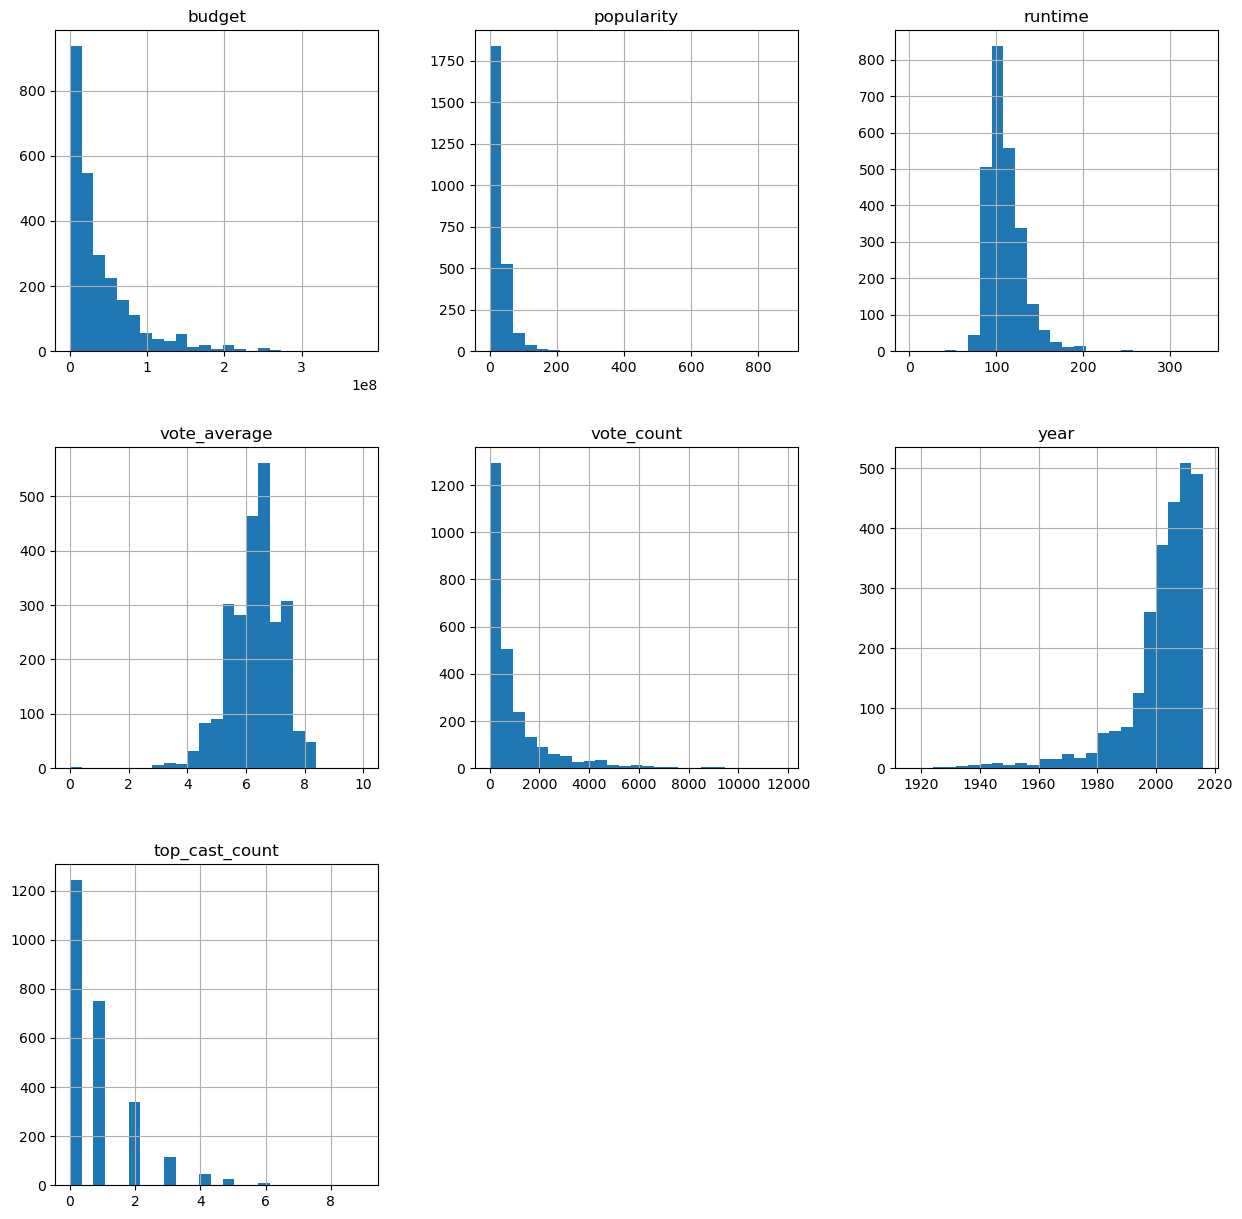

In [40]:
numeric = pd.concat([exploratory.select_dtypes(['int64', 'float64']), notional_to_numeric], axis=1)
numeric.hist(figsize=(15,15), bins=25)

In [41]:
numeric

,budget,popularity,runtime,vote_average,vote_count,year,top_cast_count
4363,0,1.862210,107.0,6.8,35,2011,0
1911,25000000,7.001176,107.0,5.2,147,2010,0
2859,12000000,47.992817,88.0,6.6,1151,2006,1
1242,40000000,3.296933,104.0,5.2,56,2001,0
732,60000000,29.018826,119.0,5.9,581,2003,2
...,...,...,...,...,...,...,...
1362,35000000,44.104469,126.0,7.0,2096,1989,0
1719,28000000,26.090746,127.0,6.3,490,1981,0
2377,18000000,31.887978,114.0,6.9,836,2008,1
1592,30000000,27.230493,131.0,6.0,506,1985,1


In [42]:
numeric.corr().style.background_gradient(cmap='RdYlGn')

,budget,popularity,runtime,vote_average,vote_count,year,top_cast_count
budget,1.000000,0.442695,0.230522,-0.027834,0.564213,0.256186,0.343589
popularity,0.442695,1.000000,0.174303,0.268295,0.733357,0.168765,0.208112
runtime,0.230522,0.174303,1.000000,0.357982,0.253121,-0.144381,0.106861
vote_average,-0.027834,0.268295,0.357982,1.000000,0.361598,-0.177188,0.062655
vote_count,0.564213,0.733357,0.253121,0.361598,1.000000,0.183148,0.295391
year,0.256186,0.168765,-0.144381,-0.177188,0.183148,1.000000,0.174617
top_cast_count,0.343589,0.208112,0.106861,0.062655,0.295391,0.174617,1.000000


<Axes: xlabel='popularity', ylabel='vote_count'>

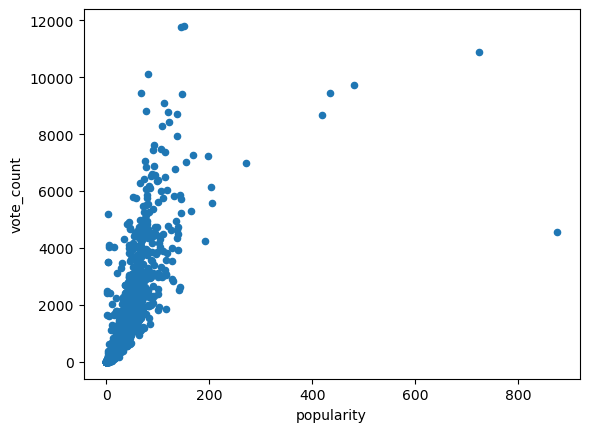

In [43]:
numeric.plot(kind='scatter', x='popularity', y='vote_count') # strongly correlated features

We had to take care of **heteroscedasticity**. Luckily log transformation took care of it. Now we have more or less the same variance of residuals across all values.
We also could notice some outliers. Let's take a look at observations with popularity higher than 400.

<Axes: xlabel='popularity', ylabel='vote_count'>

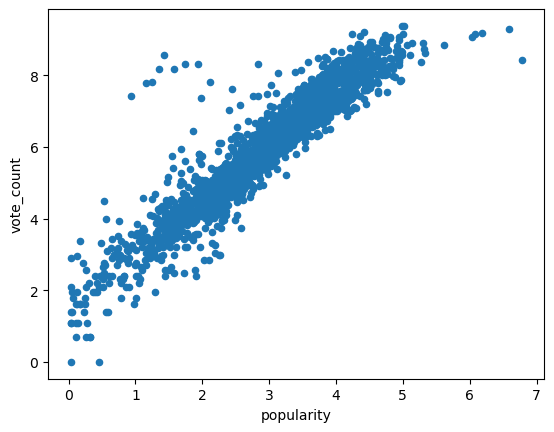

In [44]:
possible_outliers = exploratory[exploratory['popularity'] > 400]

numeric[['popularity', 'vote_count']] = np.log(exploratory[['popularity', 'vote_count']] + 1)
numeric.plot(kind='scatter', x='popularity', y='vote_count')

In [45]:
possible_outliers # huge blockbusters -> nothing to worry about then

,budget,genres,homepage,keywords,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count,cast,crew
28,150000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.jurassicworld.com/,"[{""id"": 1299, ""name"": ""monster""}, {""id"": 1718,...",en,418.708552,"[{""name"": ""Universal Studios"", ""id"": 13}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-06-09,124.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,6.5,8662,"[{""cast_id"": 10, ""character"": ""Owen Grady"", ""c...","[{""credit_id"": ""52fe4bf7c3a368484e1a0683"", ""de..."
546,74000000,"[{""id"": 10751, ""name"": ""Family""}, {""id"": 16, ""...",http://www.minionsmovie.com/,"[{""id"": 3487, ""name"": ""assistant""}, {""id"": 179...",en,875.581305,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-06-17,91.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,6.4,4571,"[{""cast_id"": 22, ""character"": ""Scarlet Overkil...","[{""credit_id"": ""5431b2b10e0a2656e20026c7"", ""de..."
95,165000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 18, ""...",http://www.interstellarmovie.net/,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,724.247784,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}, {""iso...",2014-11-05,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,8.1,10867,"[{""cast_id"": 9, ""character"": ""Joseph Cooper"", ...","[{""credit_id"": ""52fe4bbf9251416c910e4801"", ""de..."
94,170000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",http://marvel.com/guardians,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",en,481.098624,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2014-07-30,121.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,7.9,9742,"[{""cast_id"": 1, ""character"": ""Peter Quill / St...","[{""credit_id"": ""538ce329c3a3687155003358"", ""de..."
127,150000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.madmaxmovie.com/,"[{""id"": 2964, ""name"": ""future""}, {""id"": 3713, ...",en,434.278564,"[{""name"": ""Village Roadshow Pictures"", ""id"": 7...","[{""iso_3166_1"": ""AU"", ""name"": ""Australia""}, {""...",2015-05-13,120.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,7.2,9427,"[{""cast_id"": 2, ""character"": ""Max Rockatansky""...","[{""credit_id"": ""577da370c3a36817f8003838"", ""de..."


In [46]:
numeric.corr().style.background_gradient(cmap='coolwarm')

,budget,popularity,runtime,vote_average,vote_count,year,top_cast_count
budget,1.000000,0.481504,0.230522,-0.027834,0.503320,0.256186,0.343589
popularity,0.481504,1.000000,0.170185,0.333712,0.936474,0.248664,0.308056
runtime,0.230522,0.170185,1.000000,0.357982,0.180563,-0.144381,0.106861
vote_average,-0.027834,0.333712,0.357982,1.000000,0.365756,-0.177188,0.062655
vote_count,0.503320,0.936474,0.180563,0.365756,1.000000,0.254365,0.336125
year,0.256186,0.248664,-0.144381,-0.177188,0.254365,1.000000,0.174617
top_cast_count,0.343589,0.308056,0.106861,0.062655,0.336125,0.174617,1.000000


In [47]:
feature_mean = make_pipeline(FeatureSelector(['vote_count', 'popularity']), MeanTransformer('popularity_vote')).fit_transform(exploratory)
feature_mean.head()

,popularity_vote
4363,18.431105
1911,77.000588
2859,599.496409
1242,29.648467
732,305.009413


In [48]:
numeric['vote_popularity'] = feature_mean
numeric.drop(columns=['popularity', 'vote_count'], inplace=True)

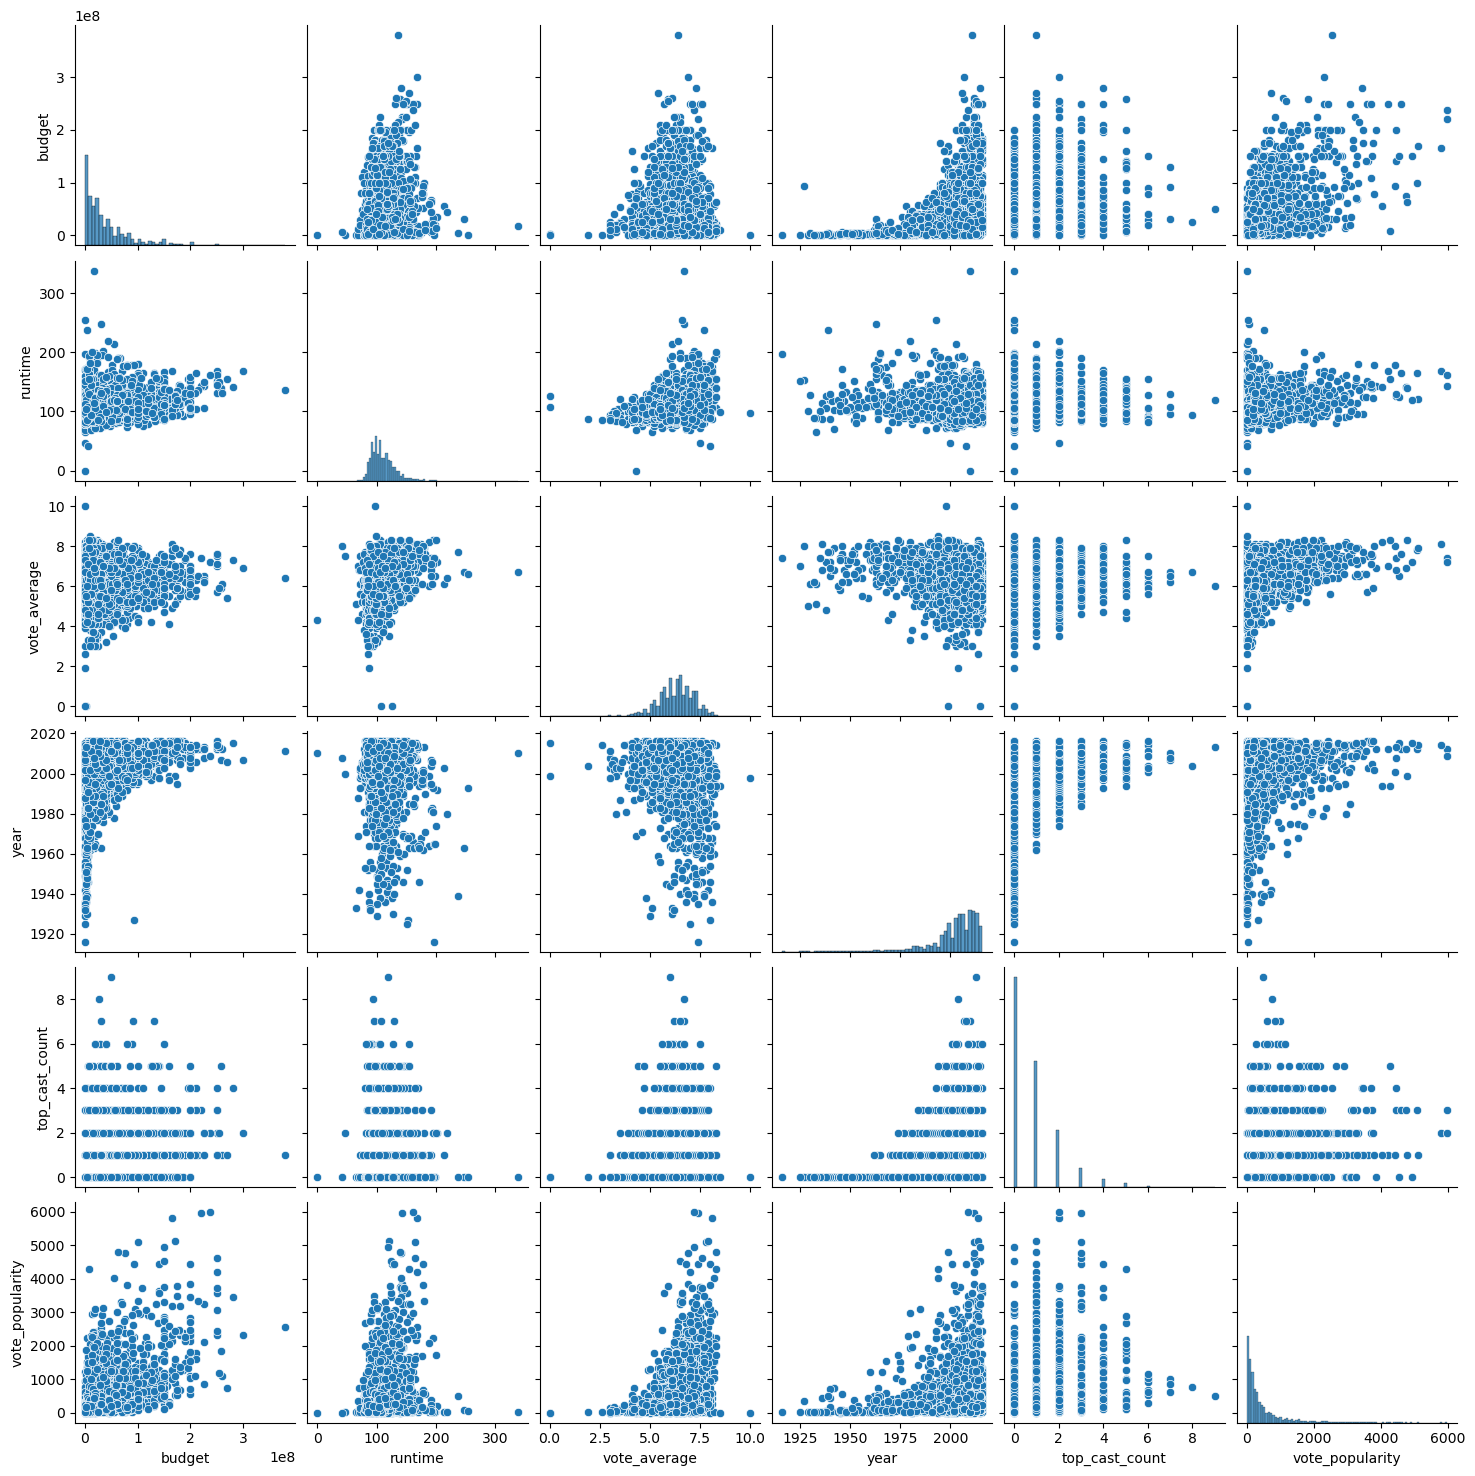

In [49]:
sns.pairplot(numeric)

R2 score - wsp. determinancji:
Informuje o tym, jaka część zmienności (wariancji) zmiennej objaśnianej w próbie pokrywa się z korelacjami ze zmiennymi zawartymi w modelu. Jest on więc miarą stopnia, w jakim model pasuje do próby. Współczynnik determinacji przyjmuje wartości z przedziału jeśli w modelu występuje wyraz wolny, a do estymacji parametrów wykorzystano metodę najmniejszych kwadratów. Jego wartości najczęściej są wyrażane w procentach. Dopasowanie modelu jest tym lepsze, im wartość R² jest bliższa jedności. Wyraża się on wzorem: 
$$R^{2}:={\frac {\sum \limits _{i=1}^{n}({\hat {y}}_{i}-{\overline {y}})^{2}}{\sum \limits _{i=1}^{n}(y_{i}-{\overline {y}})^{2}}}$$


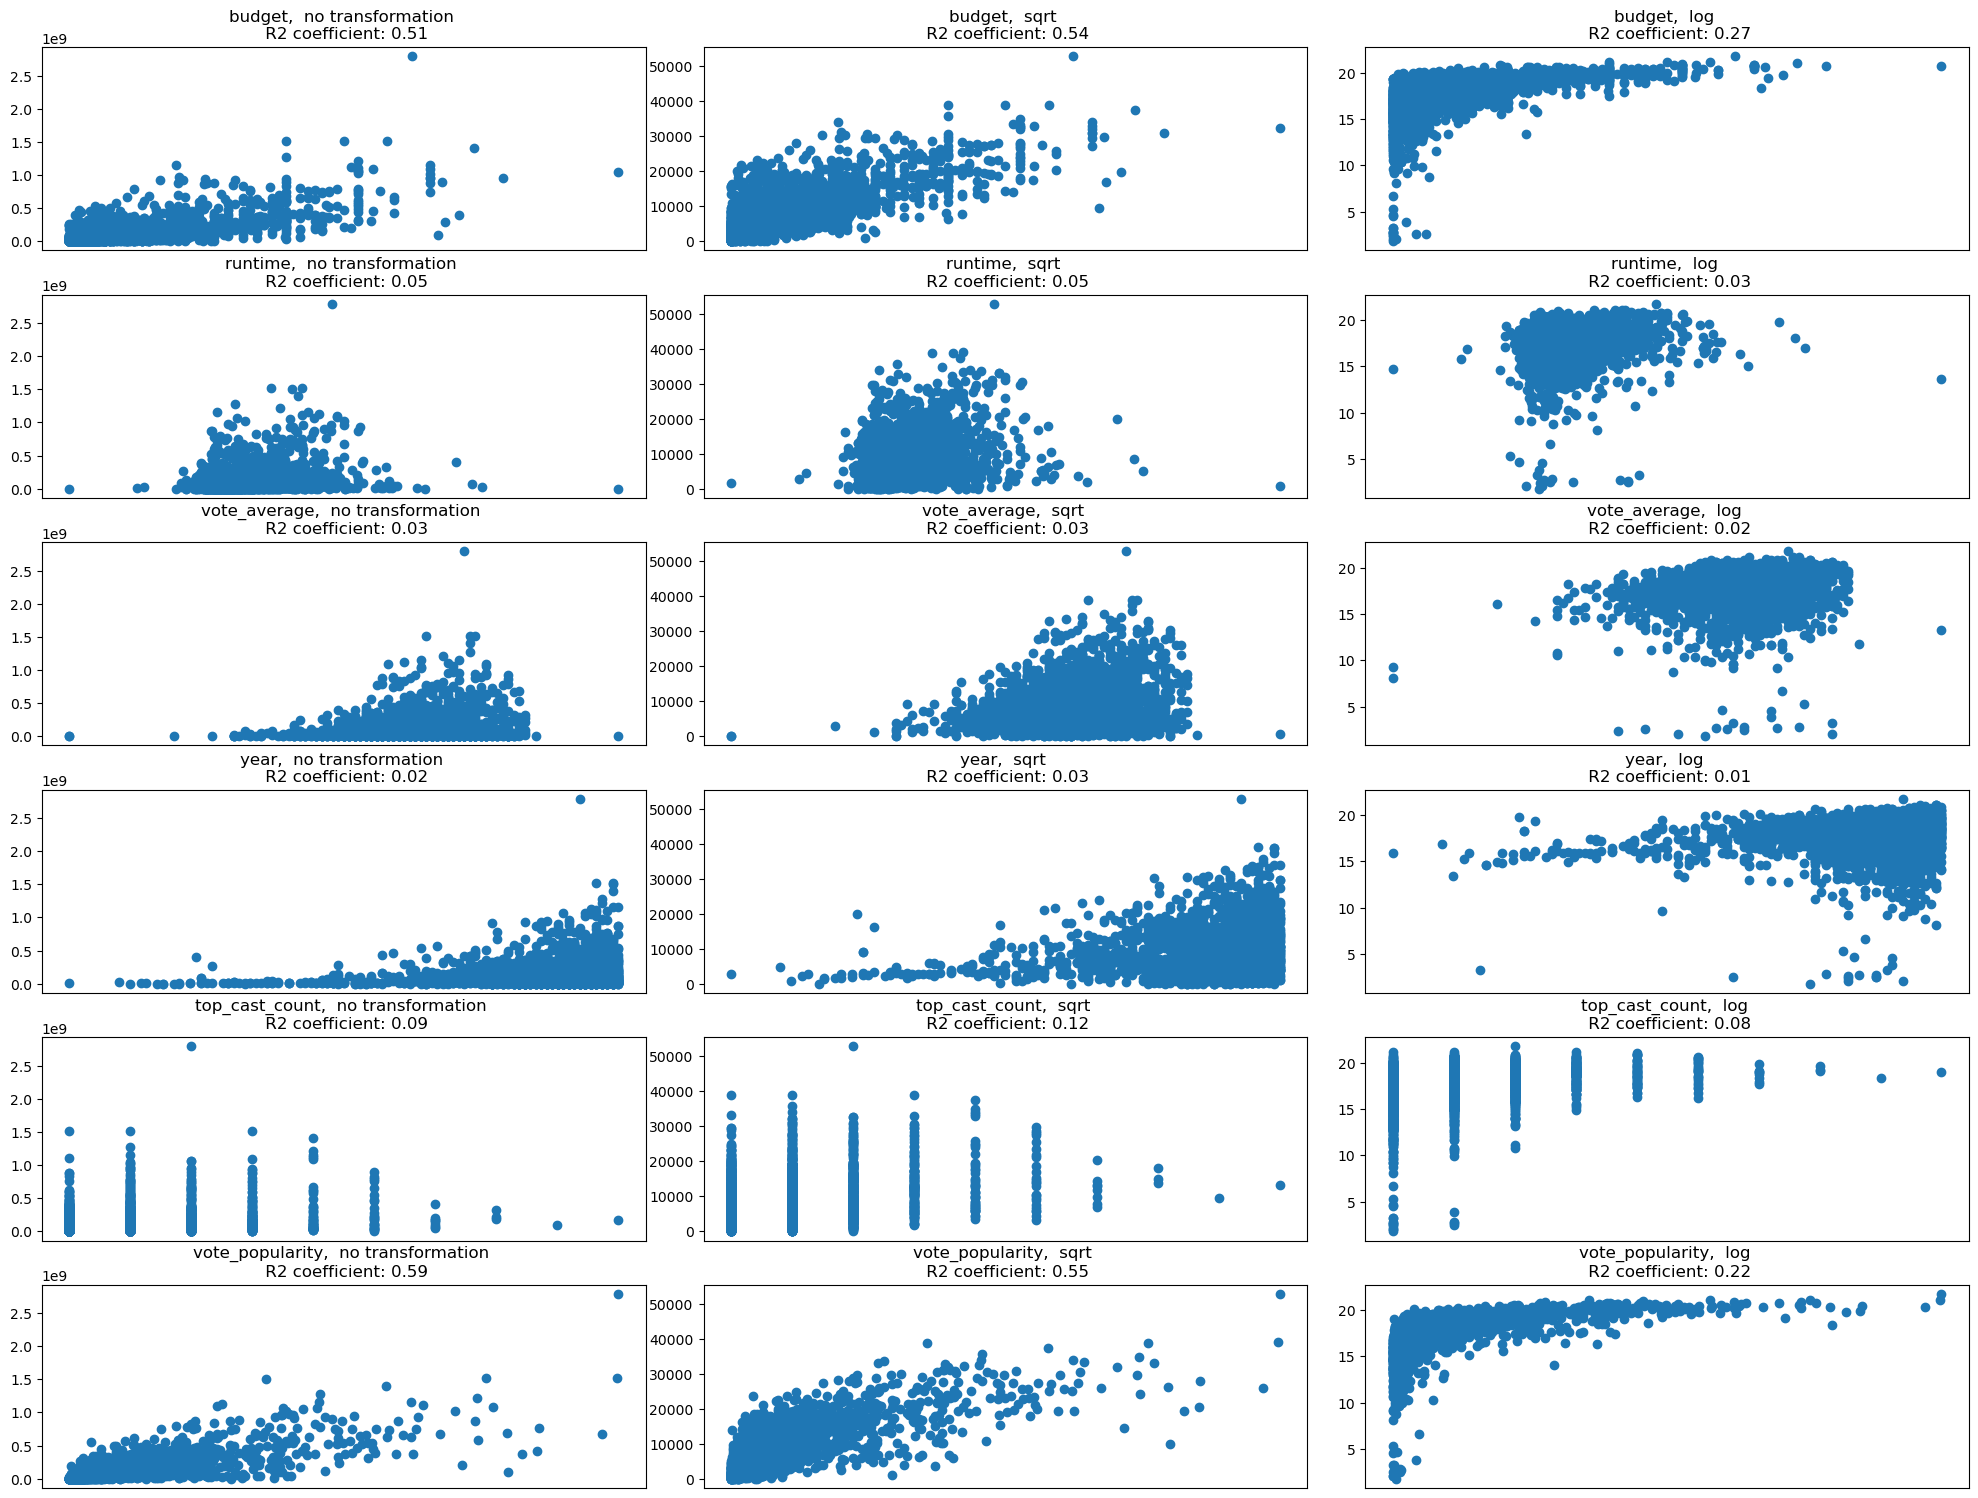

In [50]:
from scipy.stats import pearsonr

transformations = [lambda x: x, np.sqrt, lambda x: np.log(x+1)]
tran_description = [' no transformation', ' sqrt', ' log']
numeric_columns = numeric.columns

fig, axes = plt.subplots(len(numeric_columns), len(transformations), figsize=(20,15))
fig.tight_layout()

for col_idx, col in enumerate(numeric_columns):
    for tran_idx, tran in enumerate(transformations):
        axes[col_idx, tran_idx].scatter(x=numeric[col], y=tran(y_train))
        axes[col_idx, tran_idx].set_xticklabels([])
        axes[col_idx, tran_idx].set_xticks([]) 
        R2 = pearsonr(numeric[col], tran(y_train))[0]**2     
        axes[col_idx, tran_idx].title.set_text(f'{col}, {tran_description[tran_idx]} \n R2 coefficient: {R2:.2f}')
               
plt.show()

In [51]:
# TODO: 
# dokładna analiza tego co do tej pory
# modyfikacja transformerów
# zrobienie pipelinow i unionów
# predykcja z cv

# znalezienie datasetu (age-slownie, height-weight) i wykorzystanie pipe
# zabawa z kodem do innych danych
# sql

# 2. Building a pipeline

In [52]:
union = make_union(
    make_pipeline(
        FeatureSelector('genres'),
        DictionaryVectorizer('name')
    ),
    make_pipeline(
        FeatureSelector('homepage'),
        Binarizer(lambda x: isinstance(x, float), 'missing_homepage')
    ),
    make_pipeline(
        FeatureSelector('keywords'),
        DictionaryVectorizer('name'),
        TopFeatures(0.5)
    ),
    make_pipeline(
        FeatureSelector('original_language'),
        Binarizer(lambda x: x == 'en', 'en')
    ),
    make_pipeline(
        FeatureSelector('production_companies'),
        DictionaryVectorizer('name'),
        TopFeatures(1)
    ),
    make_pipeline(
        FeatureSelector('production_countries'),
        DictionaryVectorizer('name'),
        TopFeatures(25)
    ),
    make_pipeline(
        FeatureSelector('release_date'),
        DateTransformer()
    ),
    make_pipeline(
        FeatureSelector('spoken_languages'),
        ItemCounter(),
        Binarizer(lambda x: x > 1, 'multilingual')
    ),
    make_pipeline(
        FeatureSelector('original_language'),
        Binarizer(lambda x: x == 'Released', 'Released')
    ),    
    make_pipeline(
        FeatureSelector('cast'),
        DictionaryVectorizer('name'),
        TopFeatures(0.25),
        SumTransformer('top_cast_count')
    ),
    make_pipeline(
        FeatureSelector('crew'),
        DictionaryVectorizer('name', False),
        TopFeatures(1)
    ),
    make_pipeline(
        FeatureSelector(['budget', 'runtime', 'vote_average'])
    ),
    make_pipeline(
        FeatureSelector(['popularity', 'vote_count']),
        MeanTransformer('popularity_vote')
    )
)

In [53]:
%%time
union.fit(X_train)
print('Fitted')

Fitted
CPU times: user 5.01 s, sys: 79.9 ms, total: 5.09 s
Wall time: 5.09 s


In [54]:
%%time
X_train_T = union.transform(X_train)
X_test_T = union.transform(X_test)

print(X_train_T.shape)
print(X_test_T.shape)

(2534, 145)
(845, 145)
CPU times: user 2.93 s, sys: 103 ms, total: 3.04 s
Wall time: 3.05 s


In [55]:
# little post processing
def handle_same_name_col(df):
    column_names = set()
    for i, column in enumerate(df.columns):
        if column in column_names:
            print("Duplicate found")
            df.columns.values[i] = f'{column}_{i}'
        else:
            column_names.add(column)
    return df

In [56]:
X_train_T = handle_same_name_col(X_train_T)
X_test_T = handle_same_name_col(X_test_T)

Duplicate found
Duplicate found


In [57]:
X_train_T.columns.duplicated().sum()

0

# 3. Building regressor

In [ ]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

params = {
    'n_estimators': np.linspace(100, 300, 3).astype(int),
    'max_depth': [3, 4, 5, 6, 7],
}

def generate_regressor(regressor, params):
    cv = 10
    rand = True
    if rand:
        search = RandomizedSearchCV(regressor, param_distributions=params, cv=cv)
    else:
        search = GridSearchCV(regressor, param_grid=params, cv=cv)               
    return search

# xgb_search = generate_regressor(XGBRegressor(verbosity=0), params)
lgb_search = generate_regressor(LGBMRegressor(verbose=-1), params)
ctb_search = generate_regressor(CatBoostRegressor(verbose=0), params)

# xgb_search.fit(X_train_T, y_train)
lgb_search.fit(X_train_T, y_train)
ctb_search.fit(X_train_T, y_train)

# xgb_best = xgb_search.best_estimator_
lgb_best = lgb_search.best_estimator_
ctb_best = ctb_search.best_estimator_

# lgb_params = lgb_search.best_params_
# ctb_params = ctb_search.best_params_
# estimators = [('lgb', LGBMRegressor(**lgb_params, verbose=0)), 
#               ('catboost', CatBoostRegressor(**ctb_params, verbose=0))]

estimators = [('lgb', lgb_best),
             ('ctb', ctb_best)]
ensemble = StackingRegressor(estimators, final_estimator=RidgeCV())
ensemble.fit(X_train_T, y_train)

y_hat = ensemble.predict(X_test_T)

In [ ]:
r2_score(y_hat, y_test), mean_absolute_error(y_hat, y_test)

In [ ]:
y_hat = lgb_best.predict(X_test_T)
r2_score(y_hat, y_test), mean_absolute_error(y_hat, y_test)

In [ ]:
y_hat = ctb_best.predict(X_test_T)
r2_score(y_hat, y_test), mean_absolute_error(y_hat, y_test)

In [ ]:
# this is bad xd

In [ ]:
# y_hat = xgb_best.predict(X_test_T)
# r2_score(y_hat, y_test), mean_absolute_error(y_hat, y_test)
# r2, mae
# l = LGBMRegressor(lgb_p)
# l.fit(X_train_T, y_train)
# y_hat = l.predict(X_test_T)
# r2_score(y_hat, y_test), mean_absolute_error(y_hat, y_test)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV # super basic fine-tuning

params_r = {
    'n_estimators': np.linspace(100, 300, 3).astype(int),
    'max_depth': [3, 4, 5, 6, 7],  # Maximum tree depth
    'learning_rate': [0.01, 0.05, 0.1, 0.3],  # Learning rate
    'subsample': [0.5, 0.7, 0.9, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction required to make a further partition on a leaf node
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 regularization term on weights
    'reg_lambda': [0, 0.1, 0.5, 1.0],  # L2 regularization term on weights
}

params_g = {
    'n_estimators': np.linspace(100, 300, 3).astype(int),
    'max_depth': [3, 4, 5, 6, 7],  # Maximum tree depth
    'learning_rate': [0.01, 0.05, 0.1, 0.3],  # Learning rate
}

params_c = {}


# search = RandomizedSearchCV(XGBRegressor(random_state=42), params_r, cv=10)
# search = GridSearchCV(XGBRegressor(random_state=42), params_g, cv=10)
# search = RandomizedSearchCV(LGBMRegressor(random_state=42), params_r, cv=10)
search = CatBoostRegressor()

In [ ]:
search.fit(X_train_T, y_train, verbose=0)

In [ ]:
%%time
search.fit(X_train_T, y_train, verbose=0)

In [ ]:
y_hat = search.predict(X_test_T)

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2 = r2_score(y_hat, y_test)
mae = mean_absolute_error(y_hat, y_test)
r2, mae, mse

In [ ]:
import matplotlib.pyplot as plt

N = 20
x = np.arange(y_hat.shape[0])[:N]
plt.figure(figsize=(10,10))
plt.scatter(x, y_hat[:N], label='prediction')
plt.scatter(x, y_test[:N], label='truth')
# for i in range(N):
    # plt.vlines(x[i], y_hat[i], y_test[i], color='red', linestyle='dashed', linewidth=1)

plt.xticks(visible=False)
plt.legend()
plt.show()